# Manual Knowledge Graph Construction for Educational Content Recommendation

This code demonstrates the construction of a knowledge graph for educational videos using a manual, expert-driven approach. Instead of automated discovery, we explicitly define the nodes (topics) and edges (relationships) along with their corresponding weights, leveraging domain expertise to create accurate learning paths.

The system organizes content into three main domains (in this specific code example):
- Core Python programming concepts
- Financial analysis and algorithmic trading
- Bioimage analysis and microscopy

Each topic is carefully annotated with metadata including:
- Difficulty level (beginner/intermediate/advanced)
- Keywords for content identification
- Domain classification
- Detailed descriptions

Relationships between topics are manually weighted (0.0 to 1.0) to indicate:
- Prerequisite strength
- Content similarity
- Learning path progression

The resulting graph is visualized using both interactive (Pyvis) and static (Matplotlib) methods, providing clear views of the learning pathways. All graph data is stored in a SQLite database for persistence and easy querying.

While this manual approach ensures high precision and expert-curated learning paths, it requires significant effort to maintain and update. For larger content libraries, an AI-based approach (demonstrated in the next example) might be more scalable, automatically discovering relationships and adapting to new content additions.

In [1]:
!pip install pyvis networkx
# !pip install jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.7 MB/s eta 0:00:00


In [2]:
import networkx as nx
from pyvis.network import Network
import sqlite3
import json
from typing import Dict, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
import os

In [3]:
def create_topic_dictionaries():
    """Create dictionaries containing topic information for different domains"""
    # Core Python topics
    python_topics = {
        'python_basics': {
            'difficulty': 'beginner',
            'keywords': ['programming', 'syntax', 'basics'],
            'domain': 'programming',
            'description': 'Basic Python programming concepts'
        },
        'data_types_variables': {
            'difficulty': 'beginner',
            'keywords': ['variables', 'types', 'basics'],
            'domain': 'programming',
            'description': 'Python data types and variables'
        },
        'control_flow': {
            'difficulty': 'beginner',
            'keywords': ['loops', 'conditionals', 'basics'],
            'domain': 'programming',
            'description': 'Control flow in Python'
        },
        'functions_basics': {
            'difficulty': 'beginner',
            'keywords': ['functions', 'methods', 'basics'],
            'domain': 'programming',
            'description': 'Python functions fundamentals'
        },
        'data_structures': {
            'difficulty': 'intermediate',
            'keywords': ['lists', 'dictionaries', 'arrays'],
            'domain': 'programming',
            'description': 'Python data structures'
        },
        'file_handling': {
            'difficulty': 'intermediate',
            'keywords': ['files', 'io', 'data'],
            'domain': 'programming',
            'description': 'File handling in Python'
        },
        'error_handling': {
            'difficulty': 'intermediate',
            'keywords': ['exceptions', 'errors', 'debugging'],
            'domain': 'programming',
            'description': 'Error handling and debugging'
        },
        'oop_basics': {
            'difficulty': 'intermediate',
            'keywords': ['classes', 'objects'],
            'domain': 'programming',
            'description': 'Object-oriented programming basics'
        },
        'advanced_oop': {
            'difficulty': 'advanced',
            'keywords': ['inheritance', 'polymorphism'],
            'domain': 'programming',
            'description': 'Advanced OOP concepts'
        }
    }

    # Finance path topics
    finance_topics = {
        'economics_101': {
            'difficulty': 'beginner',
            'keywords': ['economics', 'markets', 'basics'],
            'domain': 'finance',
            'description': 'Basic economic concepts'
        },
        'stock_market_basics': {
            'difficulty': 'beginner',
            'keywords': ['stocks', 'trading', 'markets'],
            'domain': 'finance',
            'description': 'Stock market fundamentals'
        },
        'financial_statements': {
            'difficulty': 'intermediate',
            'keywords': ['accounting', 'finance', 'analysis'],
            'domain': 'finance',
            'description': 'Understanding financial statements'
        },
        'technical_analysis': {
            'difficulty': 'intermediate',
            'keywords': ['charts', 'patterns', 'indicators'],
            'domain': 'finance',
            'description': 'Technical analysis basics'
        },
        'financial_analysis_basics': {
            'difficulty': 'intermediate',
            'keywords': ['analysis', 'metrics', 'finance'],
            'domain': 'finance',
            'description': 'Basic financial analysis'
        },
        'python_finance': {
            'difficulty': 'intermediate',
            'keywords': ['python', 'finance', 'analysis'],
            'domain': 'finance',
            'description': 'Python for financial analysis'
        },
        'algorithmic_trading': {
            'difficulty': 'advanced',
            'keywords': ['algorithms', 'trading', 'finance'],
            'domain': 'finance',
            'description': 'Algorithmic trading with Python'
        }
    }

    # Bioimage analysis path topics
    bioimage_topics = {
        'cell_biology_basics': {
            'difficulty': 'beginner',
            'keywords': ['biology', 'cells', 'basics'],
            'domain': 'biology',
            'description': 'Basic cell biology'
        },
        'microscopy_basics': {
            'difficulty': 'beginner',
            'keywords': ['microscopy', 'imaging', 'basics'],
            'domain': 'biology',
            'description': 'Basic microscopy concepts'
        },
        'image_formats': {
            'difficulty': 'beginner',
            'keywords': ['images', 'formats', 'data'],
            'domain': 'biology',
            'description': 'Understanding image formats and metadata'
        },
        'image_analysis_basics': {
            'difficulty': 'intermediate',
            'keywords': ['image analysis', 'processing'],
            'domain': 'biology',
            'description': 'Basic image analysis'
        },
        'image_processing': {
            'difficulty': 'intermediate',
            'keywords': ['processing', 'filters', 'analysis'],
            'domain': 'biology',
            'description': 'Image processing techniques'
        },
        'python_imaging': {
            'difficulty': 'intermediate',
            'keywords': ['python', 'imaging', 'analysis'],
            'domain': 'biology',
            'description': 'Python for image analysis'
        },
        'advanced_bioimage': {
            'difficulty': 'advanced',
            'keywords': ['bioimage', 'advanced', 'analysis'],
            'domain': 'biology',
            'description': 'Advanced bioimage analysis'
        }
    }

    return python_topics, finance_topics, bioimage_topics

def define_relationships():
    """Define relationships between topics with weights"""
    return [
        # Python core path
        ('python_basics', 'data_types_variables', 1.0),
        ('data_types_variables', 'control_flow', 1.0),
        ('control_flow', 'functions_basics', 1.0),
        ('functions_basics', 'data_structures', 0.9),
        ('data_structures', 'file_handling', 0.8),
        ('data_structures', 'error_handling', 0.8),
        ('data_structures', 'oop_basics', 0.8),
        ('oop_basics', 'advanced_oop', 0.7),

        # Finance path
        ('economics_101', 'stock_market_basics', 1.0),
        ('stock_market_basics', 'financial_statements', 0.9),
        ('financial_statements', 'financial_analysis_basics', 0.9),
        ('stock_market_basics', 'technical_analysis', 0.8),
        ('python_basics', 'python_finance', 0.7),
        ('financial_analysis_basics', 'python_finance', 0.8),
        ('data_structures', 'python_finance', 0.7),
        ('technical_analysis', 'python_finance', 0.7),
        ('python_finance', 'algorithmic_trading', 0.6),

        # Bioimage path
        ('cell_biology_basics', 'microscopy_basics', 1.0),
        ('microscopy_basics', 'image_formats', 0.9),
        ('image_formats', 'image_analysis_basics', 0.9),
        ('image_analysis_basics', 'image_processing', 0.8),
        ('python_basics', 'python_imaging', 0.7),
        ('image_processing', 'python_imaging', 0.8),
        ('data_structures', 'python_imaging', 0.7),
        ('python_imaging', 'advanced_bioimage', 0.6)
    ]

In [4]:

def build_graph():
    """Build the knowledge graph with topics and relationships"""
    graph = nx.DiGraph()

    #Get the dictionaries for the topics we defined earlier
    python_topics, finance_topics, bioimage_topics = create_topic_dictionaries()

    # Combine all topics and unwrap topic and metadata
    all_topics = {**python_topics, **finance_topics, **bioimage_topics}

    # Add nodes for topic_id and assign metadata key-value pairs as attributes of the node.
    for topic_id, metadata in all_topics.items():
        graph.add_node(topic_id, **metadata)

    # Add relationships (edges)
    relationships = define_relationships()
    for from_topic, to_topic, weight in relationships:
        graph.add_edge(from_topic, to_topic, weight=weight, type='prerequisite')

    return graph, all_topics

# Build the graph
graph, topic_metadata = build_graph()

In [5]:
def visualize_graph_pyvis(graph: nx.DiGraph, topic_metadata: Dict, output_file='learning_paths.html'):
    """Create interactive visualization using Pyvis"""
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", directed=True)

    # Color map for different domains
    color_map = {
        'programming': '#add8e6',  # light blue
        'finance': '#90EE90',      # light green
        'biology': '#FA8072'       # salmon
    }

    # Add nodes
    for node in graph.nodes():
        metadata = graph.nodes[node]
        net.add_node(
            node,
            label=node.replace('_', ' ').title(),
            title=f"Domain: {metadata['domain']}\n"
                  f"Difficulty: {metadata['difficulty']}\n"
                  f"Description: {metadata['description']}",
            color=color_map[metadata['domain']]
        )

    # Add edges
    for edge in graph.edges(data=True):
        net.add_edge(edge[0], edge[1], title=f"Weight: {edge[2]['weight']}")

    try:
        net.show(output_file)
        print(f"Graph visualization saved to {output_file}")
    except Exception as e:
        print(f"Error in visualization: {e}")
        visualize_graph_matplotlib(graph)

def visualize_graph_matplotlib(graph: nx.DiGraph):
    """Create static visualization using matplotlib"""
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(graph, k=1, iterations=50)

    # Color nodes based on domain
    colors = []
    for node in graph.nodes():
        domain = graph.nodes[node]['domain']
        if domain == 'programming':
            colors.append('lightblue')
        elif domain == 'finance':
            colors.append('lightgreen')
        else:
            colors.append('salmon')

    nx.draw(graph, pos,
            node_color=colors,
            with_labels=True,
            node_size=2000,
            font_size=8,
            font_weight='bold',
            arrows=True,
            edge_color='gray',
            arrowsize=20)

    plt.title("Learning Paths Graph")
    plt.show()


learning_paths.html
Graph visualization saved to learning_paths.html


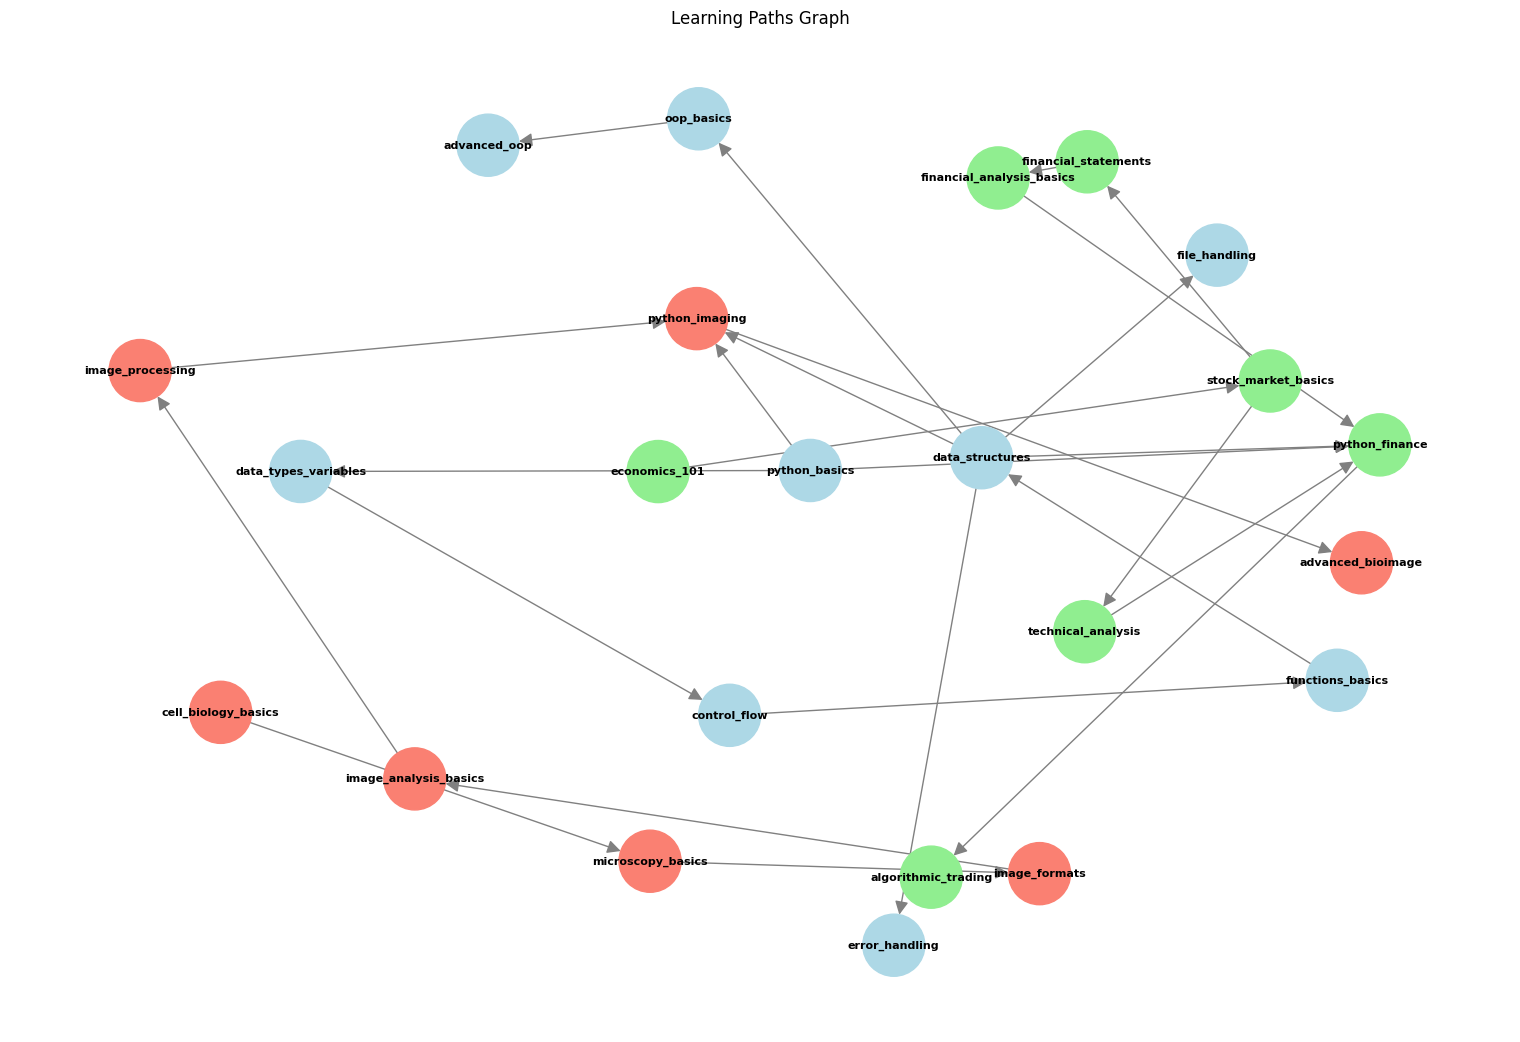

In [6]:

# Create visualizations
visualize_graph_pyvis(graph, topic_metadata)
visualize_graph_matplotlib(graph)

In [7]:
def basic_analysis(graph: nx.DiGraph):
    """Run basic analysis on the graph and display results."""
    # Calculate and display PageRank
    pagerank = nx.pagerank(graph)
    print("\nPageRank of nodes (indicating topic importance):")
    for node, rank in sorted(pagerank.items(), key=lambda x: x[1], reverse=True):
        print(f"{node}: {rank:.4f}")

    # Calculate degree centrality
    in_degree = nx.in_degree_centrality(graph)
    print("\nIn-degree centrality (topics that are important prerequisites):")
    for node, centrality in sorted(in_degree.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

    # Calculate betweenness centrality
    betweenness = nx.betweenness_centrality(graph)
    print("\nBetweenness centrality (bridge topics between domains):")
    for node, centrality in sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:5]:
        print(f"{node}: {centrality:.4f}")

In [8]:
    # Run basic analysis
    print("Running basic graph analysis...")
    basic_analysis(graph)

Running basic graph analysis...

PageRank of nodes (indicating topic importance):
algorithmic_trading: 0.0930
python_finance: 0.0899
advanced_bioimage: 0.0860
python_imaging: 0.0817
image_processing: 0.0614
data_structures: 0.0563
image_analysis_basics: 0.0527
functions_basics: 0.0468
image_formats: 0.0426
financial_analysis_basics: 0.0423
advanced_oop: 0.0392
control_flow: 0.0356
stock_market_basics: 0.0306
microscopy_basics: 0.0306
financial_statements: 0.0303
technical_analysis: 0.0288
file_handling: 0.0266
error_handling: 0.0266
oop_basics: 0.0266
data_types_variables: 0.0224
python_basics: 0.0166
economics_101: 0.0166
cell_biology_basics: 0.0166

In-degree centrality (topics that are important prerequisites):
python_finance: 0.1818
python_imaging: 0.1364
data_types_variables: 0.0455
control_flow: 0.0455
functions_basics: 0.0455

Betweenness centrality (bridge topics between domains):
data_structures: 0.0606
functions_basics: 0.0498
control_flow: 0.0346
python_finance: 0.0216
pytho

In [9]:
def get_prerequisites(graph: nx.DiGraph, topic: str, max_depth=3):
    """
    Find prerequisites for a given topic up to a specified depth.

    Args:
        graph: NetworkX directed graph
        topic: Target topic to find prerequisites for
        max_depth: Maximum depth to search for prerequisites

    Returns:
        Dict of prerequisites with their minimum distance from the target topic
    """
    if topic not in graph.nodes():
        print(f"Error: Topic '{topic}' not found in the graph")
        return {}

    prerequisites = {}
    current_depth = 1
    current_nodes = {topic}
    visited = set()

    while current_depth <= max_depth and current_nodes:
        next_nodes = set()
        for node in current_nodes:
            # Get immediate predecessors (prerequisites)
            for pred in graph.predecessors(node):
                if pred not in visited and pred not in prerequisites:
                    prerequisites[pred] = current_depth
                    next_nodes.add(pred)
            visited.add(node)
        current_nodes = next_nodes
        current_depth += 1

    return prerequisites

def print_prerequisites_analysis(graph: nx.DiGraph, topic: str):
    """Print prerequisite analysis for a given topic"""
    print(f"\nPrerequisite Analysis for: {topic}")
    print("-" * 50)

    prereqs = get_prerequisites(graph, topic)
    if not prereqs:
        return

    # Group prerequisites by depth
    depth_groups = defaultdict(list)
    for topic, depth in prereqs.items():
        depth_groups[depth].append(topic)

    # Print prerequisites by level
    for depth in sorted(depth_groups.keys()):
        print(f"\nLevel {depth} prerequisites:")
        for prereq in depth_groups[depth]:
            metadata = graph.nodes[prereq]
            print(f"- {prereq.replace('_', ' ').title()}:")
            print(f"  Difficulty: {metadata['difficulty']}")
            print(f"  Description: {metadata['description']}")

In [10]:
    # Example prerequisite analysis
    print("\nAnalyzing prerequisites...")
    print_prerequisites_analysis(graph, 'algorithmic_trading')


Analyzing prerequisites...

Prerequisite Analysis for: algorithmic_trading
--------------------------------------------------

Level 1 prerequisites:
- Python Finance:
  Difficulty: intermediate
  Description: Python for financial analysis

Level 2 prerequisites:
- Python Basics:
  Difficulty: beginner
  Description: Basic Python programming concepts
- Financial Analysis Basics:
  Difficulty: intermediate
  Description: Basic financial analysis
- Data Structures:
  Difficulty: intermediate
  Description: Python data structures
- Technical Analysis:
  Difficulty: intermediate
  Description: Technical analysis basics

Level 3 prerequisites:
- Functions Basics:
  Difficulty: beginner
  Description: Python functions fundamentals
- Financial Statements:
  Difficulty: intermediate
  Description: Understanding financial statements
- Stock Market Basics:
  Difficulty: beginner
  Description: Stock market fundamentals


In [11]:
def recommend_learning_path(graph: nx.DiGraph, domain: str):
    """
    Recommend a learning path for a specific domain (finance or bioimage).

    Args:
        graph: NetworkX directed graph
        domain: Target domain ('finance' or 'bioimage')
    """
    if domain not in ['finance', 'bioimage']:
        print("Error: Domain must be either 'finance' or 'bioimage'")
        return

    print(f"\nRecommended Learning Path for Python in {domain.title()}")
    print("-" * 50)

    # Define target nodes based on domain
    if domain == 'finance':
        target_node = 'algorithmic_trading'
        domain_identifier = 'finance'
    else:
        target_node = 'advanced_bioimage'
        domain_identifier = 'biology'

    # Find all shortest paths from python_basics to target node
    try:
        paths = nx.all_shortest_paths(graph, 'python_basics', target_node, weight='weight')
        paths = list(paths)  # Convert generator to list
    except nx.NetworkXNoPath:
        print(f"No path found from Python basics to advanced {domain} topics")
        return

    # Get the optimal path (you might want to consider weights or other factors)
    optimal_path = paths[0]  # Taking the first shortest path

    print("Recommended learning sequence:")
    for i, topic in enumerate(optimal_path, 1):
        metadata = graph.nodes[topic]
        print(f"\n{i}. {topic.replace('_', ' ').title()}:")
        print(f"   Difficulty: {metadata['difficulty']}")
        print(f"   Description: {metadata['description']}")

        # Print estimated complexity and prerequisites
        if i < len(optimal_path):
            edge_data = graph.get_edge_data(topic, optimal_path[i])
            if edge_data and 'weight' in edge_data:
                print(f"   Transition Difficulty: {(1 - edge_data['weight']) * 100:.1f}%")

    # Additional recommendations
    print("\nSupplementary topics you might find useful:")
    for node, metadata in graph.nodes(data=True):
        if (metadata['domain'] == domain_identifier and
            node not in optimal_path and
            metadata['difficulty'] != 'advanced'):
            print(f"- {node.replace('_', ' ').title()} ({metadata['difficulty']})")


In [12]:
    # Example learning path recommendations
    print("\nGenerating learning path recommendations...")
    recommend_learning_path(graph, 'finance')
    recommend_learning_path(graph, 'bioimage')


Generating learning path recommendations...

Recommended Learning Path for Python in Finance
--------------------------------------------------
Recommended learning sequence:

1. Python Basics:
   Difficulty: beginner
   Description: Basic Python programming concepts
   Transition Difficulty: 30.0%

2. Python Finance:
   Difficulty: intermediate
   Description: Python for financial analysis
   Transition Difficulty: 40.0%

3. Algorithmic Trading:
   Difficulty: advanced
   Description: Algorithmic trading with Python

Supplementary topics you might find useful:
- Economics 101 (beginner)
- Stock Market Basics (beginner)
- Financial Statements (intermediate)
- Technical Analysis (intermediate)
- Financial Analysis Basics (intermediate)

Recommended Learning Path for Python in Bioimage
--------------------------------------------------
Recommended learning sequence:

1. Python Basics:
   Difficulty: beginner
   Description: Basic Python programming concepts
   Transition Difficulty: 30.